# Purpose

#### Premise

Considering the amount of trash humans make on a daily basis, only a small fraction of that garbage gets recycled. In different households there are different ways in sorting our own waste. However in waste processing facilities can have the problem of quickly sorting through trash manually and with efficiency. Especially with growing communities, this leads to growing volumes of trash. However with certain places lacking management of waste sorting and existence of different recyclables. A problem with waste sorting managed by humans is the lack of participation and accuracy towards effective recycling.

#### Goal

The goal of this trash classifier is to properly identify the proper type of trash based on test images against a trained model trained with an organised image dataset.


## Requirements:

#### Installation:
- Ensure that you have the latest python installed.
- Ensure you have the latest version of anaconda

#### On Terminal:
Install these libraries beforehand to run this classifier:
<br>
<code>
    conda install pytorch torchvision -c pytorch
    conda install -c pytorch torchvision
</code>

In [22]:
from heading import *

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

## Defining the Classifier Environment

This section includes defining important variables including the batch size for both training and testing datasets and the transformation that will be applied to the image data.

In [23]:
training_batch_size = 5 #Defines the size of each sample for the model to iterate over.
test_batch_size = 4 #Defines the size of the sample for testing to iterate over.

In [24]:
#The transform will define the characteristics of the image/tensor being processed

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Preparing Data:
This section involves preapring the data into usable datasets that can be processed by the classifier. However these images are organised for usage through the ImageFolder method.
<br>
Image data is organised into subfolders cateogrized into different classes:
<br>
    Bottles
        <br>
        -------| bottle01.jpg
        <br>
        -------| bottle02.jpg
    <br>
    Plastics
        <br>
        -------| plastic01.jpg
        <br>
        -------| plastic02.jpg
        <br>
        -------| ....
       

In [25]:
#Create the training and testing datasets
# Load in each dataset and apply transformations using

trainset = torchvision.datasets.ImageFolder(root='./data/train/', transform=transform)
train_loader = DataLoader(trainset, training_batch_size, shuffle=True)

In [26]:
testset = torchvision.datasets.ImageFolder(root='./data/test/', transform=transform)
test_loader = DataLoader(testset, test_batch_size, shuffle=True)

In [27]:
#Define the different classes involved with the dataset
"""NOTE: These are organised by name in alphabetically"""

classes = ('HDPEBottle', 'HDPE_Dispensor', 'LDPE_PlasticBag', 'OD_Paper', 'Organic', 'PETE_DrinkBottle', 'PP_FoodContainer', 'PP_IceCreamContainer', 'PP_ReusableBag', 'PS_PlasticToy', 'PS_PlasticUtensil', 'PS_Styrofoam')

## Previewing the Training Data

This section will allow us to preview and test the prepared data and their classification with each label.

In [28]:
trainset_size = 0 #The overall size of the dataset

In [29]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Size of Training Dataset: 120
Size of classes: 12


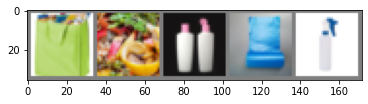

PP_ReusableBag Organic HDPE_Dispensor LDPE_PlasticBag HDPE_Dispensor


In [30]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

trainset_size = len(trainset)
print("Size of Training Dataset: " + str(len(trainset)))
print("Size of classes: " + str(len(classes)))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(training_batch_size)))

## Developing a Convolutional Neural Network

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, trainset_size) #Linear function passed with trainset size to scale with different classifications

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#Create the net
net = Net()

## Creating a Loss function and Optimiser
The loss function and optimiser will utilise a cross-entropy loss and SGD with momentum. These functions are very crucial when utilising deep learning so that they can optimise and produce much faster results. 
<br>
The loss function which is utilising Cross-Entropy that increases when the predicted probability diverges from the actual label. They areuseful to ensure that we are minimising the difference between two different probabilities. The optimiser is entailed in the name, and are used to update the weight parameters and are in conjunction with the loss functions to minimuise the loss.

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training the Network
In this section we train the model to utilise a data iterator to iterate over the datasets and feed the inputs to the network and then optimise it.

In [33]:
""" The more iterations over the model the better the prediction of the test """
for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [34]:
PATH = './train_model.pth' #Saves the model to the specified path
torch.save(net.state_dict(), PATH)

# Testing the Network

Testing the resulted training model

### Previewing the Test Images
Other than to know what images are being viewed for display, the preview will also include the labels of the ground truth of the test images. Note that these are not the actual prediction but what images the model will be tested against. As wel the test data should be similarly structured like the training data as the test also relies of the predefined classes from above.

Size of Training Dataset: 64
Size of classes: 12


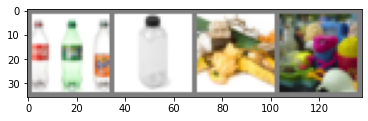

GroundTruth:  PETE_DrinkBottle PETE_DrinkBottle Organic PS_PlasticToy


In [35]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

print("Size of Training Dataset: " + str(len(testset)))
print("Size of classes: " + str(len(classes)))

# print images directly from test model
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(test_batch_size)))

### Testing the model against the images

Below we grab the model stroed in the directory and attempt to produce the prediction based on the image data it is given. Note that the test data should be structured similarly to the training data. As wel the more iterations on the training model will produce a better predction (lower = inaccurate, larger = more accurate).

In [36]:
#Next, let’s load back in our saved model 
#(note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print(predicted)


print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(test_batch_size)))

tensor([5, 5, 4, 9])
Predicted:  PETE_DrinkBottle PETE_DrinkBottle Organic PS_PlasticToy


## Checking prediction accuracy

Now as we have produced our prediction we need to see how accurately or reliably the model has performed when classifying the image. This is down with grading the accuracy of the network. 

In [38]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the ' + str(trainset_size) + ' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 120 test images: 87 %


#### Reviewing the prediction accuracy
This is performed over each defined class
<br>
<br>
IMPORTANT: Ensure that your test dataset size has a length of even numbers to do the accuracy check

In [39]:
class_size = len(classes)

class_correct = list(0. for i in range(class_size))
class_total = list(0. for i in range(class_size))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Note that tests go over the entire dataset and is dependant on batch size.
# A batch of 8 with a dataset size of 30 will lead to an out-of-bounds with last item with label-size of '6' ('8' expected)

for i in range(class_size):
    #print(i)
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of HDPEBottle : 100 %
Accuracy of HDPE_Dispensor : 71 %
Accuracy of LDPE_PlasticBag : 83 %
Accuracy of OD_Paper : 100 %
Accuracy of Organic : 100 %
Accuracy of PETE_DrinkBottle : 100 %
Accuracy of PP_FoodContainer : 75 %
Accuracy of PP_IceCreamContainer : 83 %
Accuracy of PP_ReusableBag : 100 %
Accuracy of PS_PlasticToy : 85 %
Accuracy of PS_PlasticUtensil : 83 %
Accuracy of PS_Styrofoam : 80 %
